In [1]:
import pandas as pd 
import numpy as np 
from skmultiflow.data.data_stream import DataStream
from skmultiflow.evaluation import EvaluatePrequential
import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
data=pd.read_csv('../preprocessed_data/Sebastian/preprocessed_data_a_05.csv',sep=';',header=0)
data.head()

#timestamp  left1  left2  right2  right2.1  label
0  1594215558097    -27    -94     146        54      0
1  1594215558119    -50    -98     119        50      0
2  1594215558142    -38   -106     133        40      0
3  1594215558157    -17    -68     156        82      0
4  1594215558179    -20    -78     156        77      0

In [3]:
data=data.iloc[:,-5:]
data.head()

left1  left2  right2  right2.1  label
0    -27    -94     146        54      0
1    -50    -98     119        50      0
2    -38   -106     133        40      0
3    -17    -68     156        82      0
4    -20    -78     156        77      0

In [4]:
stream=DataStream(data)
stream.prepare_for_use()

/home/brooke/envs/p3_env/lib/python3.6/site-packages/skmultiflow/data/base_stream.py:194: FutureWarning: 'prepare_for_use' has been deprecated in v0.5.0 and will be removed in v0.7.0.
New instances of the Stream class are now ready to use after instantiation.
  category=FutureWarning)


### build meta-learning model 

#### train on adaptive random forest classifier

In [32]:
from skmultiflow.meta import AdaptiveRandomForestClassifier
# Setup Adaptive Random Forest Classifier
arf = AdaptiveRandomForestClassifier()
# restart stream
stream.restart()

In [33]:
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=10000,
                                max_samples=30000,
                                batch_size = 500,
                                output_file='../reports/results_arf.csv',
                                metrics=['accuracy', 'precision','recall','f1'])

<IPython.core.display.Javascript object>


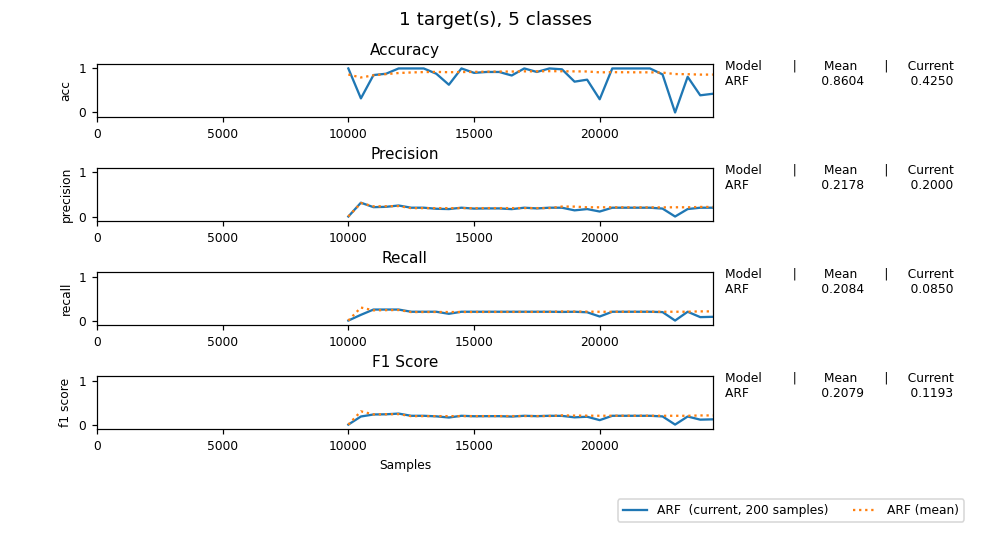

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 10000 sample(s).
Evaluating...


/home/brooke/envs/p3_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


 #################### [100%] [334.21s]
Processed samples: 25000
Mean performance:
ARF - Accuracy     : 0.8604
ARF - Precision: 0.2178
ARF - Recall: 0.2084
ARF - F1 score: 0.2079


[AdaptiveRandomForestClassifier(binary_split=False, disable_weighted_vote=False,
                                drift_detection_method=ADWIN(delta=0.001),
                                grace_period=50, lambda_value=6,
                                leaf_prediction='nba', max_byte_size=33554432,
                                max_features=2, memory_estimate_period=2000000,
                                n_estimators=10, nb_threshold=0,
                                no_preprune=False, nominal_attributes=None,
                                performance_metric='acc', random_state=None,
                                remove_poor_atts=False, split_confidence=0.01,
                                split_criterion='info_gain',
                                stop_mem_management=False, tie_threshold=0.05,
                                warning_detection_method=ADWIN(delta=0.01))]

In [34]:
evaluator.evaluate(stream=stream, model=arf, model_names=['ARF'])

#### train  without realtime visualisation

In [20]:
stream.restart()
X, y = stream.next_sample(10000)

In [21]:
#pretrain with the first 10000 data
arf = AdaptiveRandomForestClassifier()
arf.fit(X,y)

NameError: name 'nb' is not defined

In [22]:
print(arf.score(X,y))

0.9346


In [24]:
# test on the remaing samples with batch size=100 and show the developement of accuracy using the pretrained arf model
from sklearn.metrics import accuracy_score
scores = []

for i in range(int(stream.n_remaining_samples()/100)):
    
    # Receive new data instances X
    X_test, _ = stream.next_sample(100)
    
    # Compute predictions for new instances X
    y_predicted = arf.predict(X_test)
    
    # ... some time passes ...
    
    # Reception of true labels for data instances X
    y_test = stream.current_sample_y
    
    # Compute the prediction accuracy
    current_accuracy = accuracy_score(y_test, y_predicted)
    scores.append(current_accuracy)


In [25]:
def plot_figure(scores):
    plt.figure()
    plt.plot(scores)
    plt.title('Development of prediction accuracy')
    plt.xlabel('Time')
    plt.ylabel('Prediction Accuracy')
    plt.show()

    print('Mean accuracy', np.mean(scores))

In [26]:
plot_figure(scores)

<IPython.core.display.Javascript object>

Mean accuracy 0.9213888888888889


In [27]:
# use partial fit to adaptive update the classifer on new data
stream.restart()
X, y = stream.next_sample(10000)
#pretrain with the first 10000 data
arf = AdaptiveRandomForestClassifier()
arf.fit(X,y)
partial_scores = []

for i in range(int(stream.n_remaining_samples()/100)):
    
    # Receive new data instances X
    X_test, _ = stream.next_sample(100)
    
    # Compute predictions for new instances X
    y_predicted = arf.predict(X_test)
    
    # ... some time passes ...
    
    # Reception of true labels for data instances X
    y_test = stream.current_sample_y
    
    # Compute the prediction accuracy
    current_accuracy = accuracy_score(y_test, y_predicted)
    partial_scores.append(current_accuracy)

    #Update of the prediction model
    arf.partial_fit(X_test, y_test)

In [28]:
plot_figure(partial_scores)

<IPython.core.display.Javascript object>

Mean accuracy 0.9116551724137931


In [30]:
# retrain the model to adaptive updating
stream.restart()

#pretrain with the first 10000 data
arf = AdaptiveRandomForestClassifier()
arf.fit(X,y)
retrain_scores = []


for i in range(int(stream.n_remaining_samples()/100)):

    # Receive new data instances X
    X_test, _ = stream.next_sample(100)
    
    # Compute predictions for new instances
    y_predicted = arf.predict(X_test)
    
    # ... some time passes ...
    
    # Reception of true labels for data instances
    y_test = stream.current_sample_y
    
    # Compute the prediction accuracy
    current_accuracy = accuracy_score(y_test, y_predicted)
    retrain_scores.append(current_accuracy)
    
    #Retraining of the prediction model
    arf.fit(X_test, y_test)

In [31]:
plot_figure(retrain_scores)

<IPython.core.display.Javascript object>

Mean accuracy 0.9208979591836735


In [9]:
# Setup variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 30000

In [10]:
# Train the estimator with the samples provided by the data stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = arf.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    arf.partial_fit(X, y)
    n_samples += 1

In [11]:
# Display results
print('Adaptive Random Forest ensemble classifier example')
print('{} samples analbyzed.'.format(n_samples))
print('Accuracy: {}'.format(correct_cnt / n_samples))

Adaptive Random Forest ensemble classifier example
24521 samples analbyzed.
Accuracy: 0.964520207169365


#### use Streaming random patches classifer

In [35]:
from skmultiflow.meta import StreamingRandomPatchesClassifier
# Setup Streaming Random Patches Classifier
srp = StreamingRandomPatchesClassifier(random_state=1,n_estimators=3)
# restart stream
stream.restart()

In [36]:
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=16000,
                                max_samples=30000,
                                batch_size = 500,
                                output_file='../reports/results_srp.csv',
                                metrics=['accuracy', 'precision','recall','f1'])

<IPython.core.display.Javascript object>


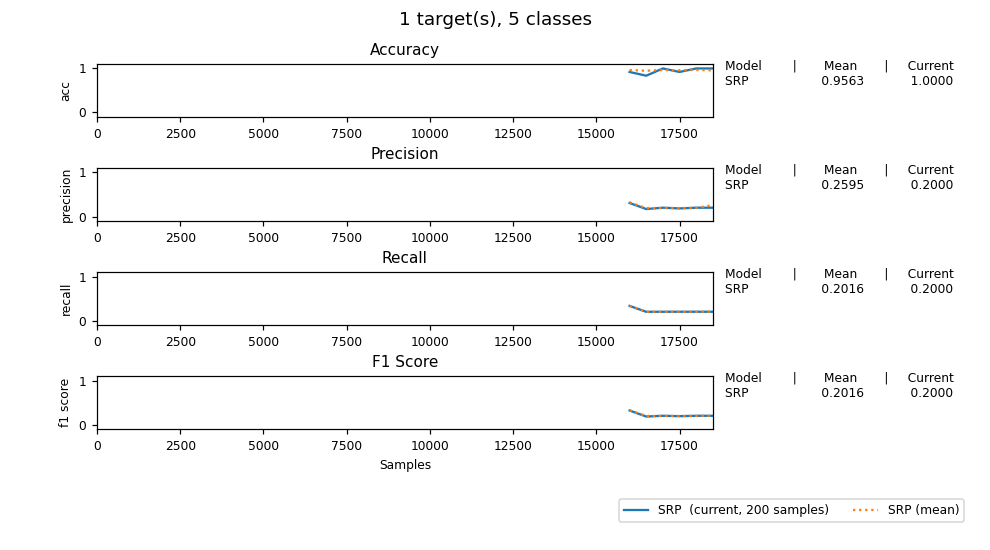

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 16000 sample(s).
Evaluating...
axis 1 is out of bounds for array of dimension 1
Processed samples: 19000
Mean performance:
SRP - Accuracy     : 0.9563
SRP - Precision: 0.2595
SRP - Recall: 0.2016
SRP - F1 score: 0.2016


/home/brooke/envs/p3_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[StreamingRandomPatchesClassifier(base_estimator=HoeffdingTreeClassifier(binary_split=False,
                                                                         grace_period=50,
                                                                         leaf_prediction='nba',
                                                                         max_byte_size=33554432,
                                                                         memory_estimate_period=1000000,
                                                                         nb_threshold=0,
                                                                         no_preprune=False,
                                                                         nominal_attributes=None,
                                                                         remove_poor_atts=None,
                                                                         split_confidence=0.01,
                                                

In [37]:
evaluator.evaluate(stream=stream, model=srp, model_names=['SRP'])

In [18]:
# Variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 30000

In [19]:
# Run test-then-train loop for max_samples
# or while there is data in the stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_pred = srp.predict(X)
    if y[0] == y_pred[0]:
        correct_cnt += 1
    srp.partial_fit(X, y)
    n_samples += 1

In [21]:
print('{} samples analyzed.'.format(n_samples))
# Display results
print('Streaming Random Patches Classifier example')
print('{} samples analyzed.'.format(n_samples))
print('Accuracy: {}'.format(correct_cnt / n_samples))

24321 samples analyzed.
Streaming Random Patches Classifier example
24321 samples analyzed.
Accuracy: 0.9539492619546893


#  Models for Imbalanced Data Streams


####  online boosting classifer and online bagging classifer

In [7]:
 from skmultiflow.meta import OnlineBoostingClassifier, OnlineSMOTEBaggingClassifier

In [6]:
# Setup the Online Boosting Classifier,SMOTEBagging ensemble classifier
online_boosting = OnlineBoostingClassifier()
online_smote_bagging = OnlineSMOTEBaggingClassifier()


In [7]:
# Set the evaluator
evaluator = EvaluatePrequential(max_samples=30000,
                            max_time=3000,
                            show_plot=True,
                            metrics=['accuracy', 'precision','recall','f1'])

<IPython.core.display.Javascript object>


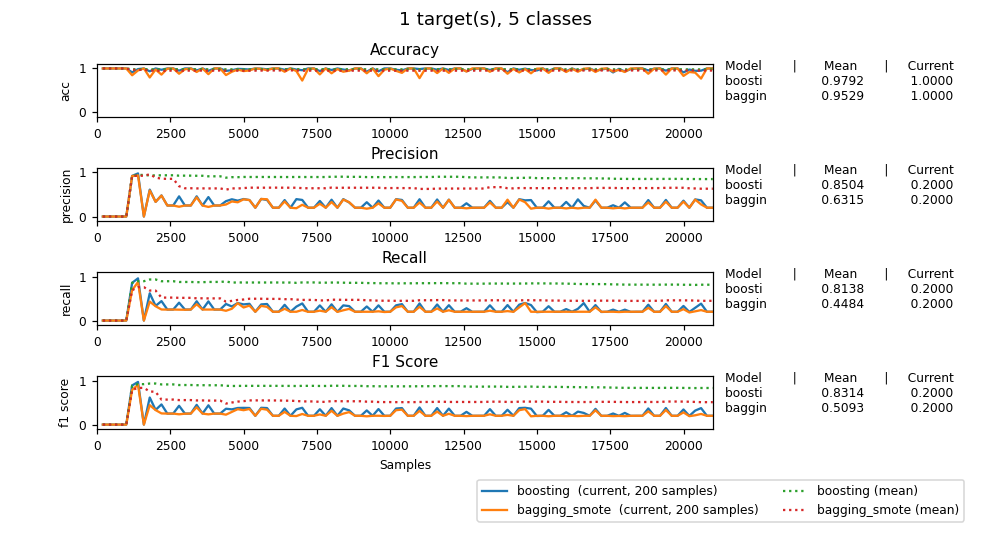

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################--- [85%] [2952.91s]
Time limit reached (3000.00s). Evaluation stopped.
Processed samples: 21041
Mean performance:
boosting - Accuracy     : 0.9792
boosting - Precision: 0.8504
boosting - Recall: 0.8138
boosting - F1 score: 0.8314
bagging_smote - Accuracy     : 0.9529
bagging_smote - Precision: 0.6315
bagging_smote - Recall: 0.4484
bagging_smote - F1 score: 0.5093


[OnlineBoostingClassifier(base_estimator=KNNADWINClassifier(leaf_size=30,
                                                            max_window_size=1000,
                                                            metric='euclidean',
                                                            n_neighbors=5),
                          drift_detection=True, n_estimators=None,
                          random_state=None),
 OnlineSMOTEBaggingClassifier(base_estimator=KNNADWINClassifier(leaf_size=30,
                                                                max_window_size=1000,
                                                                metric='euclidean',
                                                                n_neighbors=5),
                              drift_detection=True, n_estimators=10,
                              random_state=None, sampling_rate=1)]

In [8]:
evaluator.evaluate(stream=stream, model=[online_boosting,online_smote_bagging], model_names=['boosting','bagging_smote'])

<IPython.core.display.Javascript object>


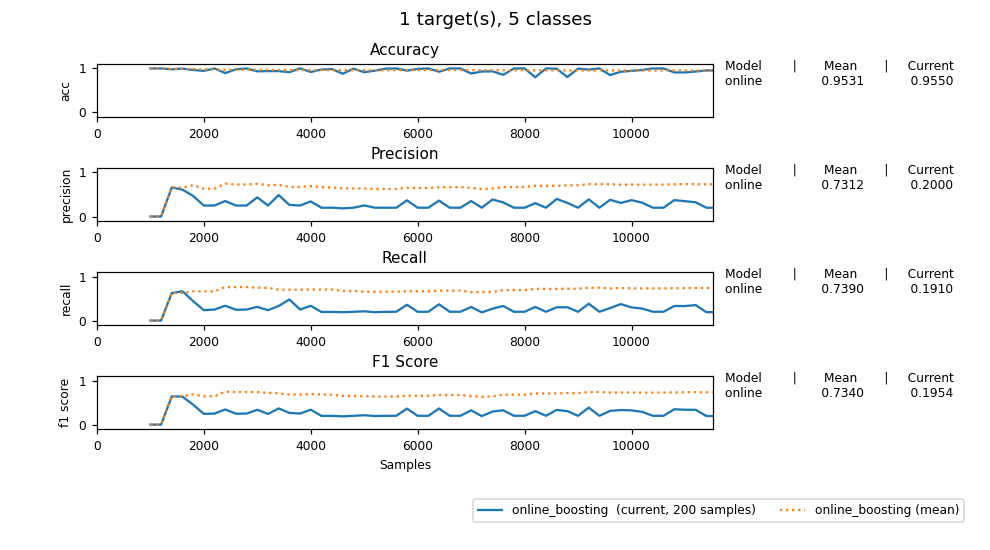

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [1338.93s]
Processed samples: 11521
Mean performance:
online_boosting - Accuracy     : 0.9531
online_boosting - Precision: 0.7312
online_boosting - Recall: 0.7390
online_boosting - F1 score: 0.7340


[OnlineBoostingClassifier(base_estimator=KNNADWINClassifier(leaf_size=30,
                                                            max_window_size=1000,
                                                            metric='euclidean',
                                                            n_neighbors=5),
                          drift_detection=True, n_estimators=None,
                          random_state=None)]

In [10]:
online_boosting = OnlineBoostingClassifier()
evaluator = EvaluatePrequential(max_samples=30000,
                                pretrain_size=1000,
                                show_plot=True,
                                metrics=['accuracy', 'precision','recall','f1'])
evaluator.evaluate(stream=stream, model=[online_boosting], model_names=['online_boosting'])

 #### use online under over bagging classifier

In [11]:
from skmultiflow.meta import OnlineUnderOverBaggingClassifier
online_under_over_bagging = OnlineUnderOverBaggingClassifier()
stream.restart()

In [12]:
evaluator = EvaluatePrequential(show_plot=True,
                                pretrain_size=1000,
                                max_samples=30000,
                                metrics=['accuracy', 'precision','recall','f1'])

<IPython.core.display.Javascript object>


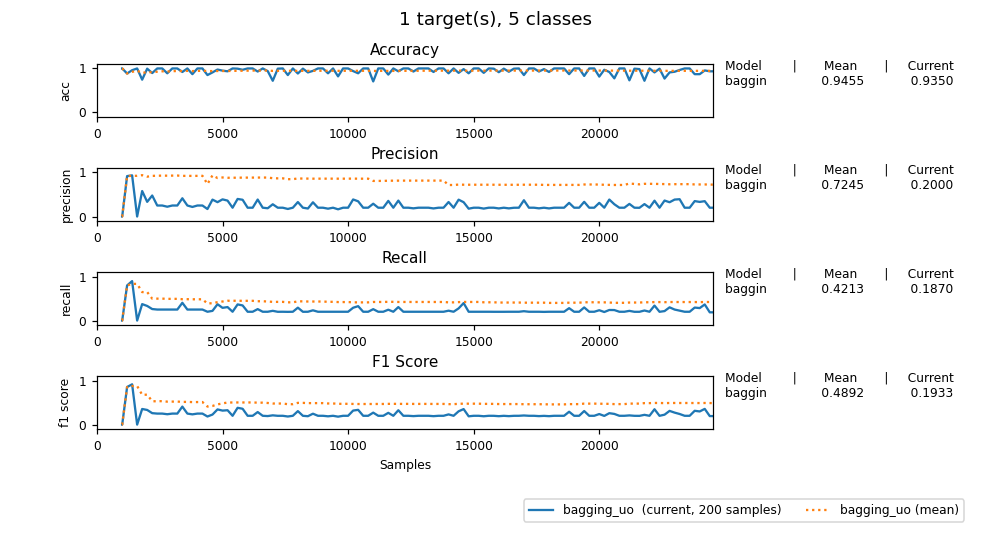

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 1000 sample(s).
Evaluating...
 #################### [100%] [965.20s]
Processed samples: 24521
Mean performance:
bagging_uo - Accuracy     : 0.9455
bagging_uo - Precision: 0.7245
bagging_uo - Recall: 0.4213
bagging_uo - F1 score: 0.4892


[OnlineUnderOverBaggingClassifier(base_estimator=KNNADWINClassifier(leaf_size=30,
                                                                    max_window_size=1000,
                                                                    metric='euclidean',
                                                                    n_neighbors=5),
                                  drift_detection=True, n_estimators=10,
                                  random_state=None, sampling_rate=2)]

In [13]:
evaluator.evaluate(stream=stream, model=[online_under_over_bagging], model_names=['bagging_uo'])

In [14]:
# Variables to control loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 30000

In [15]:
online_under_over_bagging = OnlineUnderOverBaggingClassifier()
stream.restart()

# build pipeline

In [ ]:
from skmultiflow.core import Pipeline
stream=DataStream(### data_list ###)
stream.prepare_for_use()
# restart stream if needed
stream.restart()

In [ ]:
transform = #prepocessing (####)
classifier = #Classifiername(#### paramter seting ####)

In [ ]:
# Setup the pipeline
pipe = Pipeline([('transform', transform), ('passive_aggressive', classifier)])
# Setup the evaluator
evaluator = EvaluatePrequential(show_plot=True, pretrain_size=1000, max_samples=500000)
# Evaluate
evaluator.evaluate(stream=stream, model=pipe)